# Part 2

## 1. Dataset Selection

### a. Read and preprocess the dataset

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from torch.utils.data import DataLoader, Dataset

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"GPU: {device}")

GPU: cuda


In [ ]:
dataset = pd.read_csv('AirQualityUCI.csv', delimiter=';')
dataset.describe()

,PT08.S1(CO),NMHC(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),Unnamed: 15,Unnamed: 16
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,0.0,0.0
mean,1048.990061,-159.090093,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,NaN,NaN
std,329.832710,139.789093,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,NaN,NaN
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,NaN,NaN
25%,921.000000,-200.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,NaN,NaN
50%,1053.000000,-200.000000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,NaN,NaN
75%,1221.000000,-200.000000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,NaN,NaN
max,2040.000000,1189.000000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,NaN,NaN


In [ ]:
dataset.drop(["Unnamed: 15", "Unnamed: 16"], axis = 1, inplace = True)
dataset.dropna(inplace=True)
dataset.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578"
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255"
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502"
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867"
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888"


In [ ]:
dataset['DateTime'] = dataset['Date'] + " " + dataset['Time']
dataset['DateTime'] = pd.to_datetime(dataset['DateTime'], format='%d/%m/%Y %H.%M.%S')

dataset.drop(["Date", "Time"], axis = 1, inplace = True)
dataset.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,DateTime
0,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",2004-03-10 18:00:00
1,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",2004-03-10 19:00:00
2,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",2004-03-10 20:00:00
3,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",2004-03-10 21:00:00
4,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",2004-03-10 22:00:00


In [ ]:
for i in ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']:
    dataset[i] = dataset[i].str.replace(",", ".")
    dataset[i] = dataset[i].astype('float32')

In [ ]:
new_dataset = dataset.replace(-200, np.nan)
# exclude the 2 columns with highest null values
new_dataset = new_dataset[['DateTime', 'PT08.S1(CO)',  'C6H6(GT)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'AH', 'T']]
new_dataset.isna().sum()


DateTime           0
PT08.S1(CO)      366
C6H6(GT)         366
PT08.S2(NMHC)    366
PT08.S3(NOx)     366
PT08.S4(NO2)     366
PT08.S5(O3)      366
AH               366
T                366
dtype: int64

In [ ]:
new_dataset.dropna(inplace = True)
new_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8991 entries, 0 to 9356
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DateTime       8991 non-null   datetime64[ns]
 1   PT08.S1(CO)    8991 non-null   float64       
 2   C6H6(GT)       8991 non-null   float32       
 3   PT08.S2(NMHC)  8991 non-null   float64       
 4   PT08.S3(NOx)   8991 non-null   float64       
 5   PT08.S4(NO2)   8991 non-null   float64       
 6   PT08.S5(O3)    8991 non-null   float64       
 7   AH             8991 non-null   float32       
 8   T              8991 non-null   float32       
dtypes: datetime64[ns](1), float32(3), float64(5)
memory usage: 597.1 KB


### b. Data Visualisation


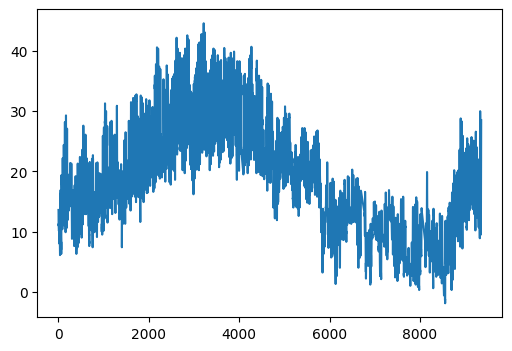

In [ ]:
# Temperature
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(new_dataset.index, new_dataset['T']);

##### We can observe a sine wave like pattern

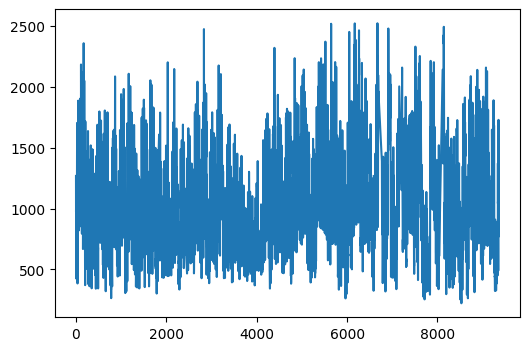

In [ ]:
# Indium Oxide concentration
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(new_dataset.index, new_dataset['PT08.S5(O3)']);

#### It's hard to find any pattern in Indium Oxide concentration

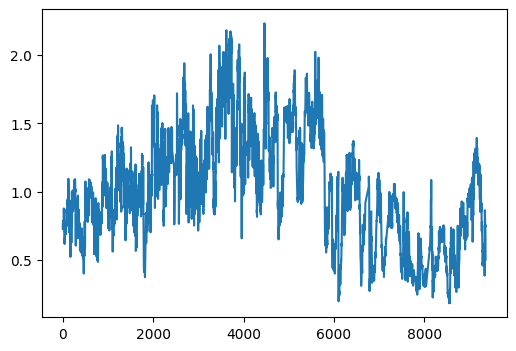

In [ ]:
# Absolute Humidity concentration
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(new_dataset.index, new_dataset['AH']);

#### May not be very evident, but there is mild sine-wave pattern followed in Humidity concentration

### c. Prepare the dataset for training

In [ ]:
sequence_length = 10
num_samples = len(new_dataset) - sequence_length
sub_data = torch.tensor([new_dataset.iloc[i:i+sequence_length, 1:-1].values for i in range(num_samples)], dtype=torch.float)

timestamps_numeric = new_dataset['DateTime'].astype(int) // 10**11
timestamp = torch.tensor([timestamps_numeric[i:i+sequence_length].values for i in range(num_samples)], dtype=torch.float32)

input_data = torch.cat((sub_data, timestamp.unsqueeze(2)), dim = 2)
print(input_data.shape)


<ipython-input-11-81e19f3b17df>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  sub_data = torch.tensor([new_dataset.iloc[i:i+sequence_length, 1:-1].values for i in range(num_samples)], dtype=torch.float)


torch.Size([8981, 10, 8])


In [ ]:
target = torch.tensor(new_dataset.iloc[sequence_length:, -1].values, dtype=torch.float).unsqueeze(1)
print(target.shape)

torch.Size([8981, 1])


In [ ]:
# Define the dataset class
class RNNData(Dataset):
    def __init__(self, dataset, target):
        self.dataset = dataset
        self.target = target

    def __getitem__(self, index):
        sequence = self.dataset[index]
        value = self.target[index]
        return sequence, value

    def __len__(self):
        return len(self.dataset)

In [ ]:
data_size = len(input_data)
train_size = int(0.7 * data_size)
val_size = int(0.15 * data_size)
test_size = data_size - train_size - val_size
rnn_dataset = RNNData(input_data, target)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(rnn_dataset, [train_size, val_size, test_size])

In [ ]:
batch_size = 8
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1)


## 2. Build RNN

a. Build the RNN model architecture, that consists of at least three RNN layers.

In [ ]:
class RNN_struct(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN_struct, self).__init__()
    self.rnn = nn.RNN(input_size, hidden_size = hidden_size, num_layers = num_layers, dropout = 0.3, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, input):
    output, _ = self.rnn(input)
    output = output[:, -1, :]
    output = self.fc(output)

    return output

b. Train RNN model and try various set ups and hyper parameters tuning. Save the weights of the trained model, that returns best results.


In [ ]:
def test_model(model, criterion):
    test_loss = []
    test_acc = []
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        output = model(inputs)
        acc = sum([1 if (t + 2 > o and  o > t - 2) else 0 for o, t in zip(output, labels)])
        test_acc.append(acc)

        loss = criterion(output, labels)
        test_loss.append(loss.item())

    test_loss = round(sum(test_loss)/(len(test_loader) * batch_size), 4)
    test_acc = round(sum(test_acc) * 100/(len(test_loader) * batch_size), 4)
    return test_loss, test_acc, output, labels

In [ ]:
def val_model(model, criterion):
    val_loss = []
    val_acc = []
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        output = model(inputs)
        acc = sum([1 if (t + 2 > o and  o > t - 2) else 0 for o, t in zip(output, labels)])
        val_acc.append(acc)

        loss = criterion(output, labels)
        val_loss.append(loss.item())

    val_loss = round(sum(val_loss)/(len(val_loader) * batch_size), 4)
    val_acc = round(sum(val_acc) * 100/(len(val_loader) * batch_size), 4)

    return val_loss, val_acc


In [ ]:
def plotting_matrix(list_metrices, epoch):
    training_acc, training_loss, validation_acc, validation_loss = list_metrices
    fig, ax = plt.subplots(1, 2, figsize = (10,5))

    ax[0].plot(range(0, epoch + 1), training_acc, label='Training Accuracy')
    ax[0].plot(range(0, epoch + 1), validation_acc, label='Validation Accuracy')
    ax[0].set_title(f'Training accuracy and validation accuracy for {epoch}')
    ax[0].legend(loc='lower right')

    ax[1].plot(range(0, epoch + 1), training_loss, label='Training Loss')
    ax[1].plot(range(0, epoch + 1), validation_loss, label='Validation Loss')
    ax[1].set_title(f'Training loss and validation loss for {epoch}')
    ax[1].legend(loc='lower right')

    plt.plot()

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=50, early_stopping = False, plot_metrics = False):
    training_accuracy = []
    validation_accuracy = []

    training_loss = []
    validation_loss = []

    best_loss = 999
    counter = 0
    threshold = 3

    for epoch in range(num_epochs):
        train_loss = []
        train_acc = []
        correct_train_pred = 0
        train_acc = []

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            output = model(inputs)
            loss = criterion(output, labels)
            acc = sum([1 if (t + 2 > o and  o > t - 2) else 0 for o, t in zip(output, labels)])

            train_loss.append(loss.item())
            train_acc.append(acc)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        val_loss, val_acc = val_model(model, criterion)

        train_loss = round(sum(train_loss)/(len(train_loader) * batch_size), 4)
        train_acc = round(sum(train_acc) * 100/(len(train_loader) * batch_size), 4)

        training_loss.append(train_loss)
        training_accuracy.append(train_acc)

        validation_loss.append(val_loss)
        validation_accuracy.append(val_acc)

        if (epoch + 1) % 10 == 0:
          print(f"Epoch {epoch+1}/{num_epochs}",  f"\nTraining Accuracy: {train_acc}%, Training Loss: {train_loss}",
                f"Validation Accuracy: {val_acc}%, Validation Loss: {val_loss}")

        if(early_stopping):
            if val_loss < best_loss:
                best_loss = val_loss
                counter = 0
            else:
                counter += 1
                if(counter >= threshold):
                  print("Early Stopping Encounter")
                  break

    if (plot_metrics):
        list_metrices = [training_accuracy, training_loss, validation_accuracy, validation_loss]
        plotting_matrix(list_metrices, epoch)

    return model

Epoch 10/100 
Training Accuracy: 8.222%, Training Loss: 34.0877 Validation Accuracy: 7.3225%, Validation Loss: 34.0746
Epoch 20/100 
Training Accuracy: 10.035%, Training Loss: 26.1861 Validation Accuracy: 8.7278%, Validation Loss: 26.1289
Epoch 30/100 
Training Accuracy: 11.5299%, Training Loss: 20.0393 Validation Accuracy: 12.6479%, Validation Loss: 19.9103
Epoch 40/100 
Training Accuracy: 15.4103%, Training Loss: 15.4738 Validation Accuracy: 15.8284%, Validation Loss: 15.288
Epoch 50/100 
Training Accuracy: 17.764%, Training Loss: 12.452 Validation Accuracy: 16.3462%, Validation Loss: 12.2049
Epoch 60/100 
Training Accuracy: 16.444%, Training Loss: 10.7994 Validation Accuracy: 15.5325%, Validation Loss: 10.4978
Epoch 70/100 
Training Accuracy: 15.4262%, Training Loss: 10.1347 Validation Accuracy: 14.7189%, Validation Loss: 9.7963
Epoch 80/100 
Training Accuracy: 15.0127%, Training Loss: 9.9503 Validation Accuracy: 15.0888%, Validation Loss: 9.5849
Epoch 90/100 
Training Accuracy: 15.

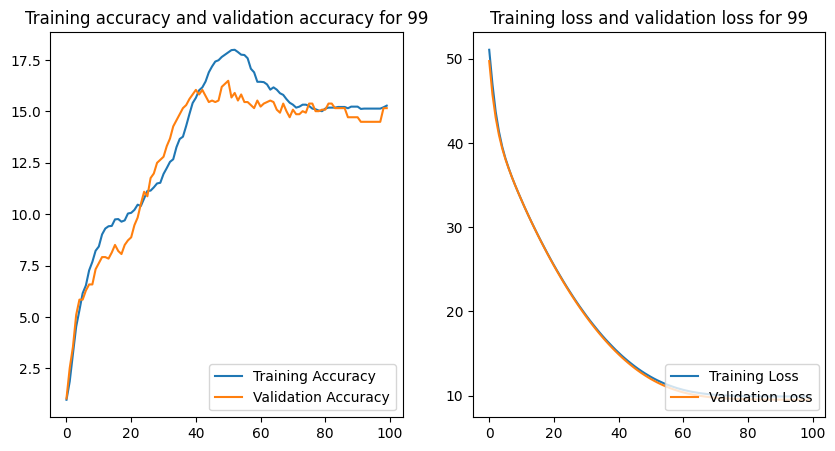

In [ ]:
input_size = 8
hidden_size = 32
output_size = 1
num_epochs = 100
num_layers = 5

rnn = RNN_struct(input_size, hidden_size, output_size).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.00001, weight_decay=0.0005)

model = train_model(rnn, criterion, optimizer, num_epochs, True, True)

In [ ]:
# save the model
PATH = './best_model.pth'
torch.save(rnn.state_dict(), PATH)

In [ ]:
loss, acc, output, y_pred = test_model(model, criterion)
print(f"testing loss: {loss}, testing accuracy: {acc}")

testing loss: 9.2859, testing accuracy: 14.8669


In [ ]:
output, y_pred

(tensor([[18.1670],
         [18.1663],
         [18.1666],
         [18.1667]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[23.6000],
         [10.6000],
         [30.3000],
         [11.8000]], device='cuda:0'))

c. Report accuracy and loss for your network


d. Visualize and analyze the results

In [ ]:
class LSTM_Struct(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(LSTM_Struct, self).__init__()
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(input_size, hidden_size = hidden_size, num_layers = num_layers, dropout = 0.5, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, input):
    output, _ = self.lstm(input)
    output = output[:, -1, :]
    output = self.fc(output)

    return output

Epoch 10/100 
Training Accuracy: 17.3982%, Training Loss: 11.5032 Validation Accuracy: 17.3077%, Validation Loss: 11.1343
Epoch 20/100 
Training Accuracy: 15.0604%, Training Loss: 9.8486 Validation Accuracy: 13.9793%, Validation Loss: 9.6609
Epoch 30/100 
Training Accuracy: 15.0763%, Training Loss: 9.8475 Validation Accuracy: 14.2751%, Validation Loss: 9.6565
Early Stopping Encounter


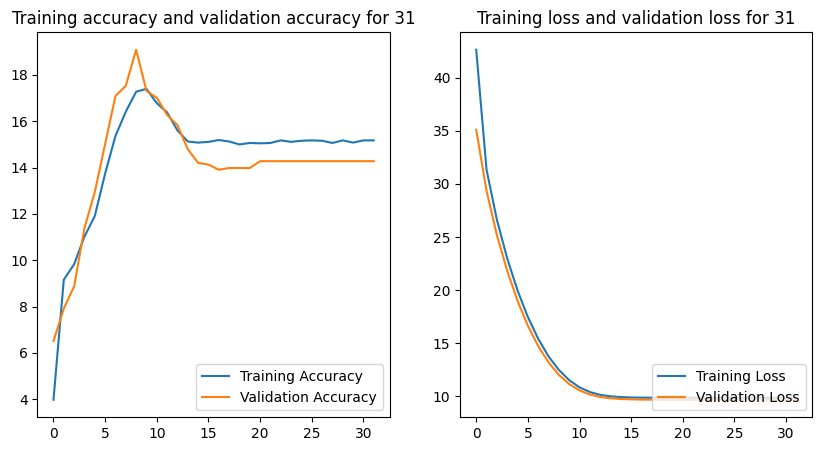

In [ ]:
input_size = 8
hidden_size = 36
output_size = 1
num_epochs = 100
num_layers = 30

rnn = LSTM_Struct(input_size, hidden_size, output_size).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.00005, weight_decay=0.0005)

model = train_model(rnn, criterion, optimizer, num_epochs, True, True)

In [ ]:
loss, acc, output, y_pred = test_model(model, criterion)
print(f"testing loss: {loss}, testing accuracy: {acc}")

testing loss: 9.7676, testing accuracy: 16.4201


In [ ]:
output, y_pred

(tensor([[18.3260],
         [18.3240],
         [18.3264],
         [18.3334]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[24.9000],
         [33.5000],
         [14.6000],
         [15.2000]], device='cuda:0'))